# Causal Marketing Attribution Simulation

**Georgios Filippou & Boi Mai Quach**

***References***: Link to the paper

# Import libraries and modules

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [2]:
import sys, os
# add project root (parent folder of the notebook) to sys.path
sys.path.append(os.path.abspath("../.."))

from causalDA.data_generation import DataGenerator
from causalDA.evaluation import compute_causal_effects
from reproduce.utils.config import NODE_LOOKUP, ACTIVITY_NAME, TARGET_NODE, EDGE_PROB, INFLUENCE_FROM_PARENTS, \
    TIME_PERIODS, BASE_RANGE, sample_conversion_dict

from reproduce.utils.helpers import snake_case, convert_effect_dict_to_links_dict
from causalDA.plotting import plot_links_graph_svg
from matplotlib import pyplot as plt

import pandas as pd
import pickle

# Gernerate synthetic data

This guide walks you through generating synthetic time series data from a random DAG (Directed Acyclic Graph) using a custom `DataGenerator`

Information:

* We begin by creating an instance of `DataGenerator`, seeding the random number generator to ensure reproducibility.
* We simulate a random DAG based on a specified edge probability. Please refer to `utils/config` to change the parameters
* We create a dictionary `conversion_dict` that maps nodes to their conversion effectiveness.
* This `dag_result` will be a nested dictionary with relationships and weights that were used to generate the data — useful for interpretability or validation.

## Causal Graph Simulation

### DAG Data Generation

In [30]:
seed = 123
gen = DataGenerator(
    node_lookup=NODE_LOOKUP,
    name_activity=ACTIVITY_NAME,
    target_node=TARGET_NODE,
    seed=seed,
)

graph = gen.generate_random_dag(edge_prob=EDGE_PROB)

conversion_dict = sample_conversion_dict()

df, dict_contributions, effect_dict = gen.generate_data(
    influence_from_parents=INFLUENCE_FROM_PARENTS,
    conversion_dict=conversion_dict,
    time_periods=TIME_PERIODS,
    base_range=BASE_RANGE,
    carryover=False,
)

dag_result = gen.get_causal_graph()

In [31]:
# Save binary graph

# Create the folder (if it doesn't exist)
folder_path = f"../examples/data/seed_{seed:04d}"
os.makedirs(folder_path, exist_ok=True)

binary_graph_path = os.path.join(folder_path, 'binary_graph.pkl')
with open(binary_graph_path, 'wb') as f:
    pickle.dump(graph, f)

print("Binary graph saved to:", binary_graph_path)

Binary graph saved to: ../examples/data/seed_0123/binary_graph.pkl


### Graph Visualisation

**Directed Acyclic Graph (DAG) Overview**
The graph depicts five marketing channels — **YouTube**, **Facebook**, **TikTok**, **Affiliates**, and **Google Ads** — and their causal paths to the target variable, **conversion**.

---
**Node Interpretation**

- **YouTube**: Influences Facebook and has a direct contribution to conversion.
- **Facebook**: Acts both as a downstream recipient of YouTube's influence and an upstream driver of TikTok, in addition to contributing to conversions directly.
- **TikTok**: Receives influence from Facebook and Affiliates, and also contributes to conversions.
- **Affiliates**: Impacts both TikTok and conversion independently.
- **Google Ads**: Influences conversions directly with no parent dependencies.
- **Conversion**: The final node representing user actions, such as purchases or sign-ups.
---

**Edges and Causal Effects**

- **YouTube → Facebook**: A negative influence, potentially due to budget cannibalization or competing messaging.
- **Facebook → TikTok**: A positive spillover effect, possibly due to coordinated campaigns or retargeting.
- **TikTok, Facebook, YouTube, Affiliates, Google Ads → Conversion**: Each channel exerts a direct causal effect on the target outcome.
- **Affiliates → TikTok**: Reflects upstream support or co-branded promotions driving TikTok traffic.

---
**Indirect and Direct Impact on Target**

In our causal graph, marketing channels can influence the target variable — **conversion** — through both **direct** and **indirect** paths.

**Direct Effects**
These are causal paths that go straight from a channel to the target without passing through any intermediate nodes.

- **YouTube → Conversion**
- **Facebook → Conversion**
- **TikTok → Conversion**
- **Affiliates → Conversion**
- **Google Ads → Conversion**

These direct links quantify the immediate impact a channel has on conversions.

**Indirect Effects**
Indirect effects occur when a channel affects another channel, which then influences the target. For example:

- **YouTube → Facebook → Conversion**
- **Facebook → TikTok → Conversion**
- **Affiliates → TikTok → Conversion**
- **YouTube → Facebook → TikTok → Conversion**

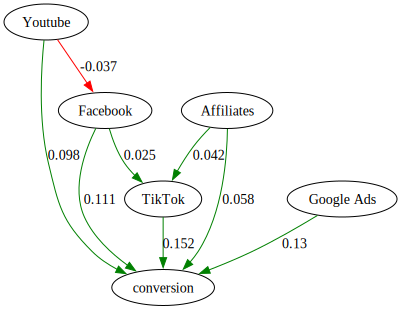

In [32]:
links_dict = convert_effect_dict_to_links_dict(effect_dict)
plot_links_graph_svg(links_dict, show_value=True, rounding=3, show_legend=False)

In [33]:
# Save DAG as a pickle file
file_path = os.path.join(folder_path, 'dag_dict.pkl')
with open(file_path, 'wb') as f:
    pickle.dump(links_dict, f)

print(f"DAG is saved to {file_path}")

DAG is saved to ../examples/data/seed_0123/dag_dict.pkl


## Marketing Attribution Data Simulation

### DataFrame Preprocessing

In [34]:
df.columns = [snake_case(col) for col in df.columns]
all_channels = [snake_case(ch) + '_' + ACTIVITY_NAME for ch in NODE_LOOKUP.values() if ch != TARGET_NODE]
target_node = snake_case(TARGET_NODE)
data = df[[target_node] + all_channels]
data.head()

,conversion,facebook_impression,google_ads_impression,tiktok_impression,youtube_impression,affiliates_impression
0,1042.360032,1149.571606,1736.523637,1832.504000,2082.097480,1859.284234
1,937.526484,1845.734550,1448.240475,1428.983113,1367.429098,1656.099055
2,851.516710,1590.946790,1279.081489,1342.971804,1434.526343,1172.305949
3,881.251624,1849.329047,1350.646140,1174.297721,1604.616113,1306.336935
4,826.186255,1000.834684,1774.714468,1197.735898,973.164755,1792.436100


### Export data

In [35]:
data_file_path = os.path.join(folder_path, 'synthetic_data.csv')
data.to_csv(data_file_path, index=False)

### Visualisation

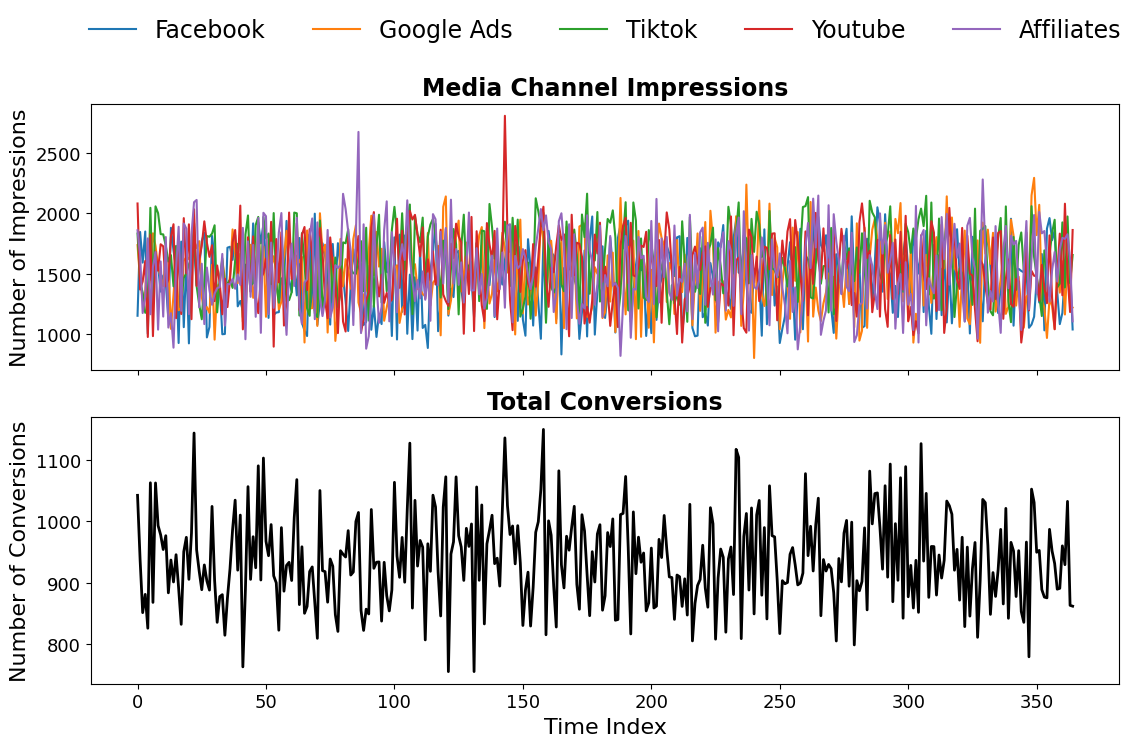

In [36]:
# Create two vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Plot 1: Media Channels ---
for channel in all_channels:
    axes[0].plot(
        df.index,
        df[channel],
        label=channel.replace("_impression", "").replace("_", " ").title()
    )

axes[0].set_title("Media Channel Impressions", fontsize=17, fontweight="bold")
axes[0].set_ylabel("Number of Impressions", fontsize=16)

# Move legend to top, in one line
axes[0].legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=len(all_channels),
    frameon=False,
    fontsize=17
)

axes[0].tick_params(axis="both", labelsize=13)

# --- Plot 2: Conversion ---
axes[1].plot(df.index, df["conversion"], color="black", linewidth=2)
axes[1].set_title("Total Conversions", fontsize=17, fontweight="bold")
axes[1].set_xlabel("Time Index", fontsize=16)
axes[1].set_ylabel("Number of Conversions", fontsize=16)
axes[1].tick_params(axis="both", labelsize=13)

# Adjust layout to leave room for top legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Total Causal Effect

In [37]:
direct_effects, total_effects = compute_causal_effects(links_dict)
print("Direct:", direct_effects)
print("Total:", total_effects)

Direct: {'Facebook': 0.11084265531555806, 'Google Ads': 0.12969511998370117, 'TikTok': 0.15213296229931655, 'Youtube': 0.09761028712256305, 'Affiliates': 0.058372648456358436}
Total: {'Youtube': 0.09332821000597882, 'Facebook': 0.11459941944800443, 'Affiliates': 0.06475197912180865, 'Google Ads': 0.12969511998370117, 'TikTok': 0.15213296229931655}


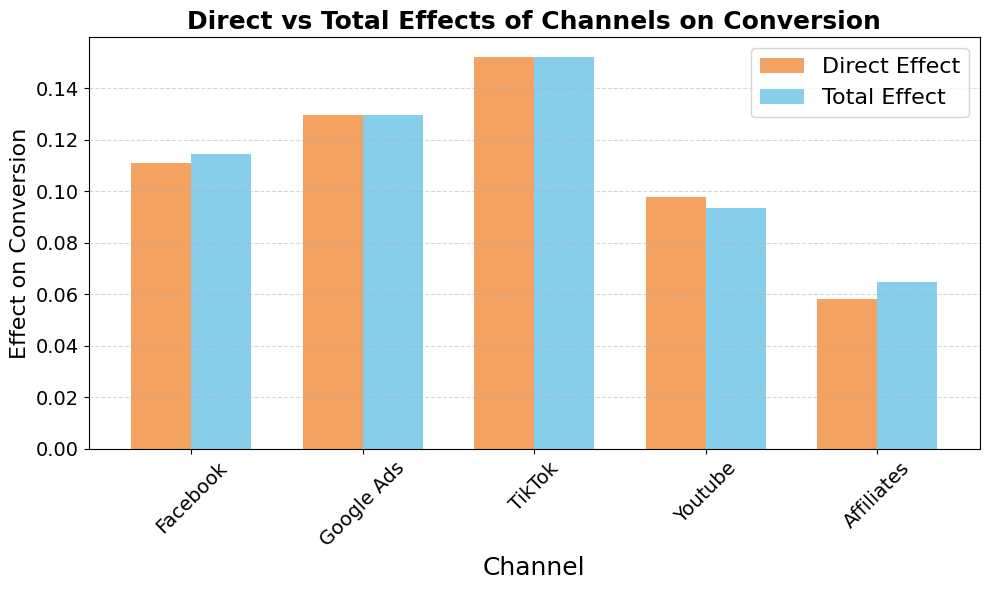

In [38]:
# Create DataFrame
df_effects = pd.DataFrame({'Direct Effect': direct_effects, 'Total Effect': total_effects})

# Custom lighter colors
light_orange = '#f4a261'
light_blue = '#87ceeb'

# Plot with consistent font sizes
fig, ax = plt.subplots(figsize=(10, 6))
df_effects.plot(
    kind='bar',
    ax=ax,
    width=0.7,
    color=[light_orange, light_blue]
)

# Style settings
ax.set_title("Direct vs Total Effects of Channels on Conversion", fontsize=18, fontweight='bold')
ax.set_ylabel("Effect on Conversion", fontsize=16)
ax.set_xlabel("Channel", fontsize=18)
ax.tick_params(axis='x', labelsize=14, rotation=45)
ax.tick_params(axis='y', labelsize=14)
ax.legend(fontsize=16, title_fontsize=16)

plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()